In [5]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
!pip install tqdm
from tqdm import tqdm
import torch.nn as nn

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
df = pd.read_csv("processed_train.csv")

In [8]:
df.head()

,Unnamed: 0,ORIGIN_STAND,TAXI_ID,LEN,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,DAY_TYPE_B,DAY_TYPE_C
0,0,0.0,366,330,7,1,0,0,0,0,1,1,0,0
1,1,7.0,370,270,7,1,0,0,0,1,0,1,0,0
2,2,0.0,203,960,7,1,0,0,0,0,1,1,0,0
3,3,0.0,329,630,7,1,0,0,0,0,1,1,0,0
4,4,0.0,216,420,7,1,0,0,0,0,1,1,0,0


In [9]:
#Removing these for this MLP model only
df = df.drop(columns=["Unnamed: 0"])
#df = df.drop(columns=["Unnamed: 0", "TRIP_ID", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "TIMESTAMP"])
#df = df.drop(columns=["Unnamed: 0", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "TIMESTAMP", "YR_2014", "YR"])

In [10]:
df_sample = df#.sample(frac=0.5)

In [11]:
df_len = df_sample["LEN"]
df_sample = df_sample.drop(columns=["LEN"])

In [12]:
len(df_sample)

1656486

In [13]:
df_sample.head()

,ORIGIN_STAND,TAXI_ID,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,DAY_TYPE_B,DAY_TYPE_C
0,0.0,366,7,1,0,0,0,0,1,1,0,0
1,7.0,370,7,1,0,0,0,1,0,1,0,0
2,0.0,203,7,1,0,0,0,0,1,1,0,0
3,0.0,329,7,1,0,0,0,0,1,1,0,0
4,0.0,216,7,1,0,0,0,0,1,1,0,0


In [14]:
features = [df_sample.iloc[i].values for i in range(len(df_sample))]

In [11]:
x = torch.tensor(np.array(features), dtype = torch.float).to(device)
y = torch.tensor(np.array(df_len.values), dtype = torch.float).to(device)

data = list(zip(x, y))
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size

train_data, test_data, val_data = torch.utils.data.random_split(data, [train_size, test_size, val_size])

In [12]:
batch_size = 15
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle = False)
# train_loader = train_data
# valid_loader = val_data
# test_loader = test_data

In [13]:
len(train_data), len(test_data), len(val_data)

(1368528, 171066, 171066)

In [14]:
learning_rate = 1e-3

In [15]:
model = torch.nn.Sequential(
    torch.nn.Linear(12, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 64),
    torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, 1024),
    #torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
).to(device)

In [16]:
loss_fn = torch.nn.MSELoss().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adagrad(model.parameters())
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [17]:
from tqdm import trange
def train_epoch(train_data, model, optimizer, loss_fn, batch_size):
    losses = []
    train_len = len(train_data)

    # get a batch of training data
    for x, y in tqdm(train_data):
        # make predictions for this batch
        y_pred = model(x)
        
        # Compute the RSME loss
        loss = torch.sqrt(loss_fn(y_pred, y))
        
        # Backpropagation
        # zero out the gradients so that it will not accumulate through each iteration
        optimizer.zero_grad()
        
        # Compute the gradents with the backward call (backprop)
        loss.backward()
        
        # Update weight using gradient descent 
        optimizer.step()
        
        losses.append(loss.item())

    return np.mean(losses)

def eval_epoch(valid_loader, model, loss_function):
    total = 0
    correct = 0
    preds = []
    trues = []
    losses = []
    with torch.no_grad(): 
        for x, y in tqdm(valid_loader):
            # Compute prediction
            y_pred = model(x)
            
            loss = torch.sqrt(loss_fn(y_pred, y))
            losses.append(loss.item())
#             total += 1
#             correct += ((y <= t+10) and (y >= t-10))
#             #trues.append(t)
#             preds.append(y)
            
    return np.mean(losses)#float(correct/total*100), preds
train_losses = []
val_losses = []

In [18]:
total_epochs = 5
train_accs, valid_accs = [], []
max_acc = 0
val_loss = 0
print(f"Training on {len(train_data)} data with batch size of {batch_size}!")
for epoch in range(total_epochs):
    
    model.train() # gradient tracking is on
    
    train_loss = train_epoch(train_loader, model, optimizer, loss_fn, batch_size)
    
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = eval_epoch(valid_loader, model, loss_fn)
    val_losses.append(val_loss)
    scheduler.step()
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:>0.4f}, Validation Loss {val_loss:>0.4f}\n")

Training on 1368528 data with batch size of 3!


  0%|          | 0/456176 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 57022/57022 [00:36<00:00, 1579.02it/s]


Epoch: 1, Train Loss: 419.9147, Validation Loss 418.2424



100%|██████████| 57022/57022 [00:34<00:00, 1641.27it/s]


Epoch: 2, Train Loss: 417.6164, Validation Loss 418.4354



100%|██████████| 57022/57022 [00:37<00:00, 1528.44it/s]


Epoch: 3, Train Loss: 416.8979, Validation Loss 417.5487



100%|██████████| 57022/57022 [00:36<00:00, 1567.43it/s]


Epoch: 4, Train Loss: 416.8533, Validation Loss 417.5425



100%|██████████| 57022/57022 [00:35<00:00, 1600.11it/s]

Epoch: 5, Train Loss: 416.9163, Validation Loss 417.5225



In [19]:
model.eval()
eval_epoch(test_loader, model, loss_fn)

100%|██████████| 57022/57022 [00:35<00:00, 1585.50it/s]


421.71661150000983

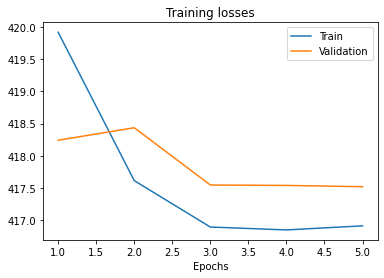

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure()
e = len(train_losses)
x_axis = np.arange(1, e + 1, 1)
plt.plot(x_axis, train_losses, label = "Train")
plt.plot(x_axis, val_losses, label = "Validation")
plt.legend()
plt.title('Training losses')
plt.xlabel("Epochs")
plt.show()

In [21]:
df_sample.head()

,ORIGIN_STAND,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A,DAY_TYPE_B,DAY_TYPE_C
0,0.0,7,1,0,0,0,0,1,1,0,0
1,7.0,7,1,0,0,0,1,0,1,0,0
2,0.0,7,1,0,0,0,0,1,1,0,0
3,0.0,7,1,0,0,0,0,1,1,0,0
4,0.0,7,1,0,0,0,0,1,1,0,0


In [22]:
# count = 0
# loss_dict = {}
# with torch.no_grad(): 
#     for index, row in df_sample.iterrows():
#         x = torch.tensor(row.values, dtype=torch.float).to(device)
#         y_pred = model(x)

#         loss = torch.sqrt(loss_fn(y_pred, y[count]))
#         count += 1

#         loss_dict[index] = loss

In [23]:
# indexes = list(sorted(loss_dict))
# indexes[-11:-1]

In [24]:
df_orig = pd.read_csv("processed_train.csv")

In [25]:
torch.save(model, "MLP4")

In [26]:
#model = torch.load("MLP2.5")

In [27]:
df_test = pd.read_csv("processed_test.csv")
df_out = df_test["TRIP_ID"].to_frame()
df_test = df_test.drop(columns=["Unnamed: 0", "TRIP_ID", "ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID", "TIMESTAMP"])

In [28]:
x_test = [torch.tensor(df_test.iloc[i].values,dtype=torch.float).to(device) for i in range(len(df_test))]

In [29]:
model.eval()
with torch.no_grad(): 
    df_out["TRAVEL_TIME"] = [float(model(x).cpu()) for x in x_test]
df_out.head()
# # mean(716.43) -> 792.73593
# # median(600) -> 784.74219
df_out.to_csv("my_pred.csv", index=None)

In [30]:
#TODO Implement accuracy or smthing for training
#Do something with validation (make a validation set)